# Double lane change test

A standard test of passenger vehicle dynamics and road holding ability is the
double lane change test. The test conditions and track layout are specified in
[ISO 3888-1:2018](https://www.iso.org/standard/67973.html). 

The double lane change test can be used to evaluate Electronic stability control
([ESC](https://en.wikipedia.org/wiki/Electronic_stability_control)), lane
following; emergency avoidance; and other
[ADAS](https://en.wikipedia.org/wiki/Advanced_driver-assistance_system) or
automated driving functions. For all of these a key control signal is the yaw
rate (or derivatives of it). InertialSim allows developers and analysts to
understand how measurement errors in this signal may affect their algorithms.
They can do this in virtual environments, iterating and scaling rapidly to
complement real-world track testing.

We simulate the double lane change test using the [CARLA](https://carla.org/)
simulator on the University of Michigan [Mcity Digital
Twin](https://github.com/mcity/mcity-digital-twin) track.

## Create the CARLA scenario

In [ ]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# This example is licensed under the CC BY-NC-SA 4.0 license.
# https://creativecommons.org/licenses/by-nc-sa/4.0/
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
# Note: Launch the CARLA simulator before running this cell
#       CARLA 0.9.15 prebuilt requires Python 3.7
%matplotlib widget

from dlc import DoubleLaneChange

scenario = DoubleLaneChange()
scenario.spawn_vehicle()
scenario.spawn_spectator()
scenario.spawn_cones()
scenario.spawn_imu()
# Uncomment to add a camera recording the scene
# scenario.spawn_camera()

## Run the scenario

The standard test procedure is run at 80 kilometers per hour.  Since CARLA's
built-in vehicle controllers are quite basic, we run it at 60 km/h instead.  We
record data to a csv file but we could have connected the CARLA IMU callback to
InertialSim directly for real-time results and in order to use simulated IMU
data in an improved vehicle controller.

In [ ]:
scenario.drive(speed=60.0)

<video autoplay loop>
    <source src="../images/dlc.webm" type="video/webm">
</video>

## Plot CARLA outputs

The simulator outputs the angular rates of the vehicle. As expected, the
majority of the signal is in the yaw rate as the vehicle aggressively changes
lane, however a significant amount of angular rate is also present in the roll
rate due to inertia and suspension effects and in the pitch rate as the vehicle
brakes to a halt at the end of the test.

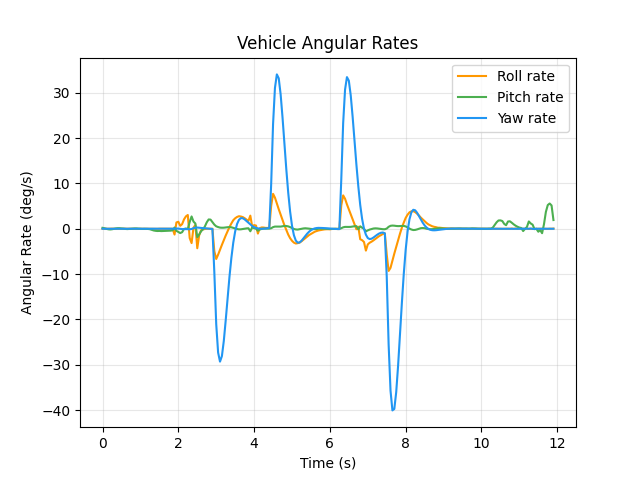

In [2]:
# Note: InertialSim requires Python 3.10+

import numpy as np
from inertialsim import plot
from inertialsim.geometry import Vector

path = "carla_data/dlc.csv"
data = np.genfromtxt(path, dtype=float, delimiter=",")

angular_rate = Vector.from_xyz(data[:, 2:5], time=data[:, 1] - data[0, 1])

yrp = plot.TimeSeries(title="Vehicle Angular Rates", ylabel="Angular Rate (deg/s)")
yrp.line(angular_rate.time, np.rad2deg(angular_rate.as_xyz()))
yrp.legend(["Roll rate", "Pitch rate", "Yaw rate"])

## Simulate a high performance and a low-cost IMU

We simulate a high performance reference IMU as is typically used in test
vehicles (often integrated as part of an INS/GNSS system) and a lower cost,
lower accuracy sensor that might be a candidate for use in mass production.

At the macro-level there is little discernible difference between the true yaw
rate and that measured by the (simulated) high performance gyro or the
(simulated) low-cost gyro. See the figure below.

Looking at finer resolution, however, illustrates key differences. In the zoom
inset, which illustrates a 2 second sub-maneuver to correct a lane offset, the
much larger bias and noise levels of the low-cost gyro are visible. The high
performance gyro tracks the true yaw rate very precisely. Note that it is not
possible to visually differentiate scale factor, bias, misalignment and many of
the error terms discussed above so these assessments are subjective.
InertialSim provides developers and analysts with the ability to assess the
relevance (or lack thereof) of each of these error sources independently against
ground-truth.

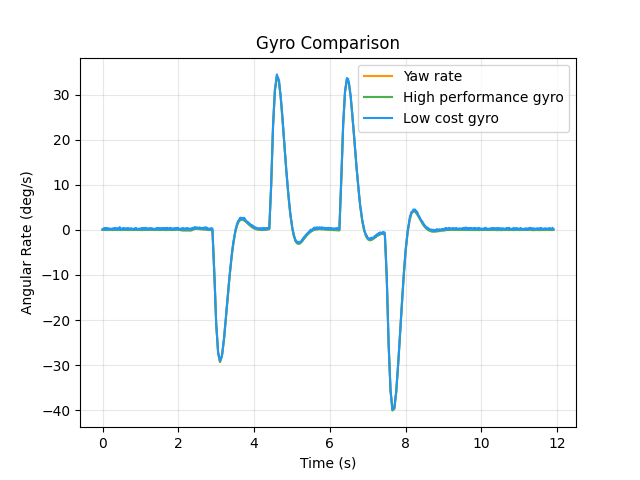

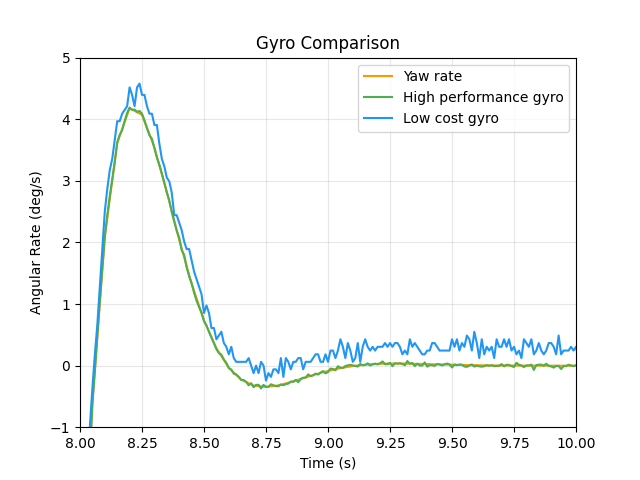

In [3]:
from inertialsim.devices.imu import honeywell_hg1700
from inertialsim.devices.imu import bosch_bmi270
from inertialsim.sensors import Parameter
from inertialsim.sensors.gyro import Gyro, GyroModel

# Simulate at a common 100Hz
model = GyroModel()
honeywell_hg1700.data_interface.sample_rate = Parameter(100.0, "Hz")
laser_gyro = Gyro(model, honeywell_hg1700, rng=0)
mems_gyro = Gyro(model, bosch_bmi270, rng=1)

# Simulate a high precision ring laser gyro
rlg_result = laser_gyro.simulate(angular_rate=angular_rate)

# Simulate a low-cost MEMS gyro
mems_result = mems_gyro.simulate(angular_rate=angular_rate)

# Plot the entire result
ar = plot.TimeSeries(title="Gyro Comparison", ylabel="Angular Rate (deg/s)")
ar.line(angular_rate.time, np.rad2deg(angular_rate.as_xyz()[:, 2]))
ar.line(rlg_result.angular_rate.time, np.rad2deg(rlg_result.angular_rate.data[:, 2]))
ar.line(mems_result.angular_rate.time, np.rad2deg(mems_result.angular_rate.data[:, 2]))
ar.legend(["Yaw rate", "High performance gyro", "Low cost gyro"])

# Plot a smaller region of interest
arz = plot.TimeSeries(title="Gyro Comparison", ylabel="Angular Rate (deg/s)")
arz.line(
    angular_rate.time,
    np.rad2deg(angular_rate.as_xyz()[:, 2]),
    xlimits=[8.0, 10.0],
    ylimits=[-1.0, 5.0],
)
arz.line(rlg_result.angular_rate.time, np.rad2deg(rlg_result.angular_rate.data[:, 2]))
arz.line(mems_result.angular_rate.time, np.rad2deg(mems_result.angular_rate.data[:, 2]))
arz.legend(["Yaw rate", "High performance gyro", "Low cost gyro"])